This notebook is to test the efficiency of cell-list data structure to guess bonds between atoms along with comparison with present implementation of distances array for guessing bonds. The function is modified using a helper function to compare different size of datasets. Finally, the time reduction for uessing of bonds is shown using the test universe available in MDAnalysis.Tests.

In [226]:
import numpy as np
from MDAnalysis.lib.distances import distance_array
import cellgrid
from MDAnalysis.lib.pkdtree import PeriodicKDTree
import itertools

In [227]:
import importlib
importlib.reload(cellgrid)

<module 'cellgrid' from '/home/karan/miniconda3/envs/mda/lib/python3.6/site-packages/cellgrid-0.1.0-py3.6-linux-x86_64.egg/cellgrid/__init__.py'>

In [228]:
def bf_guessbond( points, atoms = None,  box = None):
    """
    Guess the bonds of particles
    Two atoms form bonds if d < f*(R1 + R2)
    """
    if atoms is None:
        ### Use default values
        vdw = 1.0
        atoms = np.ones(len(points), dtype = np.float32)*vdw
    else:
        ##First check if every atom radius correspond to one particle
        if len(points) != len(atoms):
            print("Atoms and Coordinates should have equal length")
            return
        ####Every atom corresponds to a radius for its respective particle
        
    fudge_factor = 0.72
    lower_bound = 0.1

    
    bonds = []
    # Define a maximum distance for every atom to search based on the radius 
    # of the atom and maximum radius of atom in the atom list.
    max_vdw = np.amax(atoms) 
    
    # Self distance use very high amount of memory for large particles
    # Individual particles should be used instead of sparse matrix 
    # for all the pairs
    for i,coordinate in enumerate(points):
        vdw_i = atoms[i]
        max_d = (vdw_i + max_vdw) * fudge_factor
        dist = distance_array(points[i][None, :], points[i + 1:],box=box)[0]
        idx = np.where((dist > lower_bound) & (dist <= max_d))[0]
        for a in idx:
            j = i + 1 + a
            atom_j = points[j]
            if dist[a] < (atoms[j] + vdw_i)*fudge_factor:
                bonds.append((i, j))
    return tuple(bonds)

In [229]:
def cg_guessbonds(points, atoms = None, box = None):
    """
    Guessing Bonds with cell-List data structures
    """ 
    if atoms is None:
        ### Use default values
        vdw = 1.0
        atoms = np.ones(len(points), dtype = np.float32)*vdw
    else:
        ##First check if every atom radius correspond to one particle
        if len(points) != len(atoms):
            print("Atoms and Coordinates should have equal length")
            return
        
    fudge_factor = 0.72
    lower_bound = 0.1
    
    bonds = []

    max_vdw = np.amax(atoms)
    
    indx,dist = cellgrid.capped_self_distance_array(points, 2.0*max_vdw*fudge_factor, box=box[:3])
    mask = np.where((dist <= (2.0*max_vdw)*fudge_factor) & (dist > lower_bound))
    for num, (i,j) in enumerate(indx[mask]):
        if dist[mask][num] < (atoms[i] + atoms[j]) * fudge_factor:
            bonds.append((i,j))  
    return tuple(bonds)
    

In [363]:
def kd_guessbonds(points, atoms = None, box = None):
    """
    Already implemented tree structure in MDAnalysis
    """
    if atoms is None:
        ### Use default values
        vdw = 1.0
        atoms = np.ones(len(points), dtype = np.float32)*vdw
    else:
        ##First check if every atom radius correspond to one particle
        if len(points) != len(atoms):
            print("Atoms and Coordinates should have equal length")
            return
        
    fudge_factor = 0.72
    lower_bound = 0.1

    bonds = []
    
    max_vdw = np.amax(atoms)
    
    kdtree = PeriodicKDTree(box, bucket_size=10)
    kdtree.set_coords(points)
    
    for idx,centers in enumerate(points):
        vdw_i = atoms[idx]
        max_d = (vdw_i + max_vdw)*fudge_factor
        kdtree.search(centers,max_d)
        indices = kdtree.get_indices()
        dist = distance_array(centers.reshape((1,3)), points[indices],box=box)[0]
        index = np.where((dist > lower_bound) & (dist <= max_d))[0]
        #if index.shape[0] != 0:
        #    print("Index:",dist[index[0]])
        for j in index:
            if (indices[j] > idx) and (dist[j] < (atoms[indices[j]] + vdw_i)*fudge_factor):
                bonds.append((idx, j)) 
    return tuple(bonds)
    

For a single type of atom, lets check the time to guess bonds

In [382]:
#Initialization
BOX = np.array([100., 100., 100., 90., 90., 90.], dtype = np.float32)
NPOINTS = 10000

In [383]:
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

In [384]:
points = get_coords(BOX, NPOINTS)

In [385]:
bonds = bf_guessbond(points, box = BOX)
print(len(bonds))

595


In [386]:
cgbonds = cg_guessbonds(points, box = BOX[:3])
len(cgbonds)

595

In [387]:
kdbonds = kd_guessbonds(np.array(points, dtype = np.float32), box = BOX)
print(len(kdbonds))

595


In [392]:
time_bf = %timeit -q -o -n 1 -r 1 bf_guessbond(points, box = BOX)

In [393]:
time_cg = %timeit -q -o -n 1 -r 1 cg_guessbonds(points, box = BOX[:3])

In [394]:
time_kd = %timeit -q -o -n 1 -r 1 kd_guessbonds(points, box = BOX)

In [395]:
time_bf.average, time_cg.average, time_kd.average

(2.265078000000358, 0.3237649999973655, 1.4388460000009218)

Cell Grid performs better for 1000 particles. Lets check the variation of time for guessing bonds with number of particles, provided a constant bond length i.e all particles are similar.

In [396]:
#Initial Setup
NPOINTS = np.logspace(2, 4.5, num = 10, dtype = np.int32)
BOX = np.array([100., 100., 100., 90., 90., 90.], dtype = np.float32)

In [398]:
from tqdm import tqdm_notebook
from collections import defaultdict

time = defaultdict(list)
for N in tqdm_notebook(np.unique(NPOINTS)):
    points = get_coords(BOX, N)
    
    
    ##Tests
    bf_bonds = bf_guessbond(points, box = BOX)
    cg_bonds = cg_guessbonds(points, box = BOX[:3])
    #kd_bonds = kd_guessbonds(points, box = BOX)
    
    for a, b in itertools.combinations([bf_bonds, cg_bonds], 2):
        print("Testing ",N, a, b)
        np.testing.assert_equal(len(a),len(b))
        print("Passed")

    #Brute Force
    time_bf = %timeit -q -o -n 1 -r 1 bf_guessbond(points, box = BOX)
    time['bf'].append(time_bf.average)
    
    #Cellgrid
    time_cg = %timeit -q -o -n 1 -r 1 cg_guessbonds(points, box = BOX[:3])
    time['cg'].append(time_cg.average)
    
    #KDTree
    time_kd = %timeit -q -o -n 1 -r 1 kd_guessbonds(points, box = BOX[:3])
    time['kd'].append(time_kd.average)

    time['N'].append(N)

Testing  100 () ()
Passed
Testing  189 () ()
Passed
Testing  359 () ()
Passed
Testing  681 ((61, 679), (221, 484)) ((679, 61), (221, 484))
Passed
Testing  1291 ((10, 1023), (123, 1026), (145, 200), (195, 287), (195, 661), (281, 441), (366, 481), (397, 520), (427, 917), (483, 818), (530, 612), (590, 1253), (674, 1156), (804, 1139), (820, 937), (1021, 1229), (1097, 1271), (1186, 1216)) ((123, 1026), (612, 530), (483, 818), (590, 1253), (1139, 804), (674, 1156), (441, 281), (661, 195), (287, 195), (1097, 1271), (200, 145), (481, 366), (1021, 1229), (427, 917), (520, 397), (1186, 1216), (10, 1023), (820, 937))
Passed
Testing  2448 ((20, 2220), (78, 550), (110, 251), (179, 1820), (388, 1743), (421, 1184), (496, 947), (514, 1999), (759, 2115), (842, 2087), (855, 2171), (856, 1522), (974, 1195), (980, 985), (1059, 2040), (1066, 1922), (1101, 1102), (1180, 2180), (1215, 1466), (1275, 1599), (1298, 1898), (1507, 2297), (1514, 2018), (1548, 1777), (1944, 2379)) ((985, 980), (2220, 20), (1507, 22

Testing  16681 ((2, 5802), (6, 1659), (9, 16346), (10, 13629), (16, 5084), (21, 14924), (30, 2795), (30, 11819), (38, 4021), (39, 3227), (58, 1239), (59, 13021), (62, 14791), (72, 12348), (80, 9000), (82, 3601), (88, 500), (95, 14115), (100, 315), (109, 14930), (118, 8011), (118, 15699), (123, 4267), (123, 12513), (123, 14897), (124, 16188), (137, 11974), (146, 8110), (152, 4500), (160, 8523), (165, 3532), (168, 15984), (170, 14287), (195, 9198), (196, 5299), (199, 3926), (203, 6028), (206, 8793), (209, 6701), (217, 8745), (226, 5106), (226, 8185), (228, 2164), (233, 3073), (247, 10830), (257, 1893), (268, 11671), (269, 9042), (271, 9371), (273, 9236), (273, 9243), (274, 5759), (277, 2852), (279, 13333), (287, 12666), (289, 12874), (294, 14303), (304, 12883), (315, 10395), (316, 2191), (318, 7896), (325, 9030), (326, 10715), (327, 11805), (329, 9047), (329, 15246), (337, 2694), (345, 8850), (345, 12339), (349, 10723), (350, 8624), (350, 9298), (357, 579), (358, 1896), (362, 13397), (36

Testing  31622 ((3, 17060), (5, 3281), (7, 2804), (7, 28023), (9, 23125), (13, 27491), (15, 17549), (15, 23714), (17, 20136), (20, 2858), (23, 3478), (23, 10440), (24, 9057), (24, 15686), (25, 26500), (27, 24825), (31, 19036), (33, 25018), (34, 4607), (35, 26454), (39, 20112), (41, 24000), (42, 22841), (48, 24074), (48, 25505), (52, 20853), (53, 24189), (55, 12512), (57, 14345), (57, 19360), (60, 5951), (68, 28626), (71, 25256), (72, 5768), (79, 21545), (90, 8554), (101, 22118), (104, 23241), (105, 11609), (108, 22946), (110, 18292), (110, 28459), (111, 4535), (111, 4753), (117, 12466), (118, 10550), (129, 21297), (134, 28128), (136, 7019), (137, 28498), (138, 18477), (139, 29583), (149, 23761), (149, 26421), (150, 6315), (150, 7826), (151, 23454), (152, 23320), (154, 24416), (155, 19562), (157, 5441), (158, 13284), (159, 2149), (164, 22226), (166, 7664), (171, 18828), (173, 21393), (174, 15704), (175, 31411), (178, 12189), (180, 1999), (183, 28019), (183, 31458), (184, 23331), (186, 4

In [399]:
time

defaultdict(list,
            {'bf': [0.004982999998901505,
              0.007166999999753898,
              0.015556999998807441,
              0.032390999997005565,
              0.07304699999804143,
              0.1902070000032836,
              0.5607720000007248,
              1.8459409999995842,
              5.92334099999789,
              20.588510000001406],
             'cg': [0.011643999998341314,
              0.009047999999893364,
              0.00991500000236556,
              0.01326100000005681,
              0.0232560000004014,
              0.03793500000028871,
              0.11635000000023865,
              0.30674699999872246,
              0.4491170000001148,
              1.1149139999979525],
             'kd': [0.0347540000002482,
              0.023585999999340856,
              0.054294000001391396,
              0.07352100000207429,
              0.18226400000276044,
              0.2767070000008971,
              0.6246059999975841,
              1.075387

In [141]:
%matplotlib inline

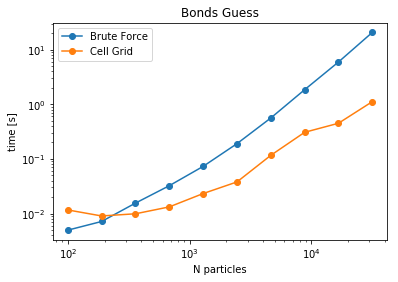

In [400]:
import matplotlib
import matplotlib.pyplot as plt
fig, axes = plt.subplots()

#axes.plot(time['N'], time['kd'], 'o-', label='PeriodicKDT')
axes.plot(time['N'], time['bf'], 'o-', label='Brute Force')
axes.plot(time['N'], time['cg'], 'o-', label='Cell Grid')
axes.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Bonds Guess')
axes.legend()

Suppose every particle has a certain vanderwall radius. The objective is now to distribute a vaue of random radius to each particle and check the timing with different number of particles. 